## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.tree import DecisionTreeRegressor

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data = data.resample('1H').sum()

# 2. Анализ

In [4]:
data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


In [5]:
data.tail(1)

,num_orders
datetime,
2018-08-31 23:00:00,205


In [6]:
data.sample(n=5,random_state=12345)

,num_orders
datetime,
2018-03-19 15:00:00,48
2018-08-01 13:00:00,93
2018-06-29 04:00:00,95
2018-03-30 02:00:00,45
2018-05-10 14:00:00,90


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
data.sort_index(inplace=True)

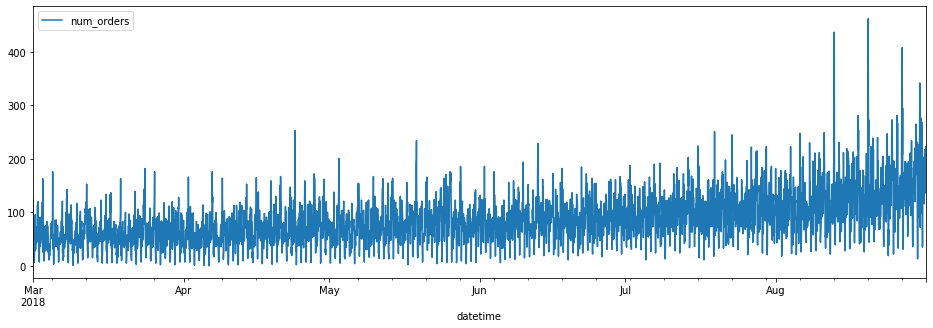

In [9]:
data.plot(figsize=(16, 5))

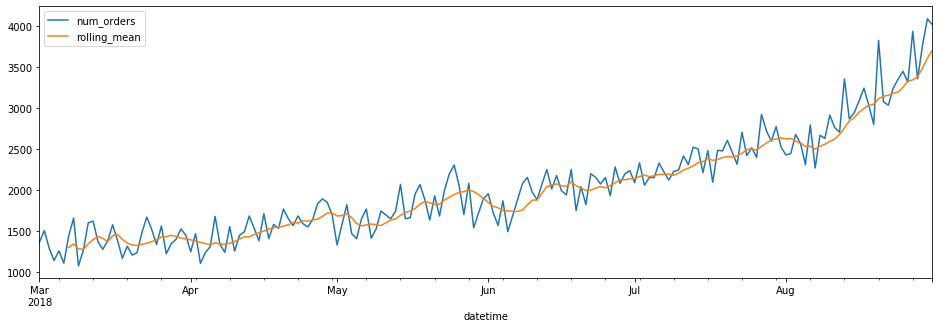

In [10]:
x = data['2018-03':'2018-08'].resample('1D').sum()
x['rolling_mean'] = x.rolling(7).mean()
x.plot(figsize=(16, 5))

In [11]:
decomposed = seasonal_decompose(data)

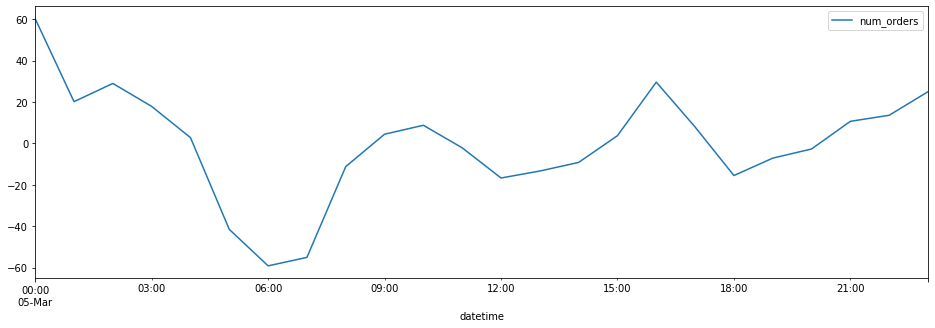

In [12]:
decomposed.seasonal['2018-03-05':'2018-03-05'].plot(figsize=(16, 5))

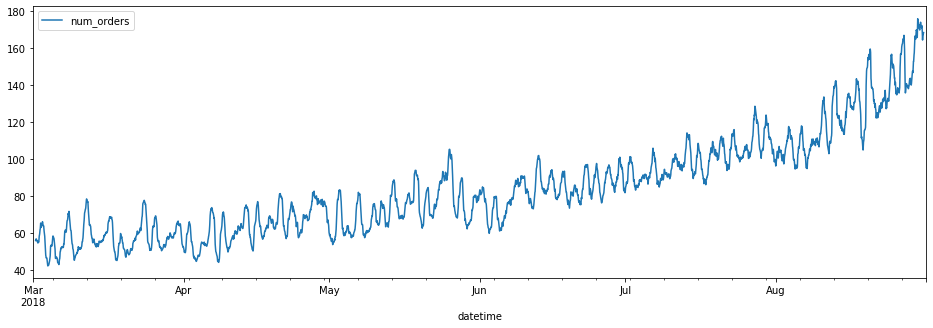

In [13]:
decomposed.trend.plot(figsize=(16, 5))

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Сезонности как таковой никакой не наблюдается, даже какого-то увеличения поездок к выходным (если это можно отнести к сезонности). А вот тренд к увеличению поездок с начала летнего сезона виден отчетливо, возможно, к кончу сезона отпусков, количество поездок тоже сократится.
</div>

<div class="alert alert-block alert-info">
<b>Совет (ревью 3):</b> На графике сезонности видно, что присутствует дневная сезонность (графики за каждый день совпадают).
</div>

# 3. Обучение

In [14]:
df = pd.DataFrame([[1]])

In [15]:
def make_features(data_f, max_lag, rolling_mean_size):
    df = data_f.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

<div class="alert alert-block alert-info">
<b>Код ревьюера (ревью 2): </b>
</div>

In [16]:
import pandas as pd

df = pd.DataFrame([[1]])
df

,0
0,1


In [17]:
def plus_one(data):
    data_new = data.copy()
    data_new = data_new + 1

    return data_new

In [18]:
df_new = plus_one(df)

In [19]:
df

,0
0,1


In [20]:
df_new

,0
0,2


<div class="alert alert-block alert-info">
<b>Конец кода ревьюера (ревью 2). </b> Исходный датафрейм не изменился.
</div>

<div class="alert alert-block alert-success">
<b>Успех (ревью 3):</b> Теперь все верно, молодец!
</div>

<div class="alert alert-block alert-info">
<b>Совет (ревью 2): </b> Исходя из графика сезонности можно выбрать параметр max_lag таким образом, что качество сильно улучшится. Подсказка: его нужно увеличить.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Для модели случайного леса я пробовала разные датафреймы с разными признаками. Дальше есть регрессия и дерево. Все проверяются на валидационной выборке. А на тестовой - только финальный тест.
</div>

In [21]:
def learning_valid (model, features_train, target_train, features_valid, target_valid):
    model.fit(features_train,target_train)
    predicted_valid=model.predict(features_valid)
    x = mean_squared_error(target_valid,predicted_valid)**0.5
    return x

<font color='blue'> <b>df_4_4.</b>

In [22]:
df_4_4 = make_features(data, 1, 4)

In [23]:
df_4_4 = df_4_4.dropna()
train_4_4, test_4_4 = train_test_split(df_4_4, shuffle = False, test_size = 0.1)
train_4_4, valid_4_4 = train_test_split(train_4_4, shuffle = False, test_size = 0.25)

In [24]:
target_train_4_4 = train_4_4['num_orders']
features_train_4_4 = train_4_4.drop(['num_orders'],axis=1)

In [25]:
target_valid_4_4 = valid_4_4['num_orders']
features_valid_4_4 = valid_4_4.drop(['num_orders'],axis=1)                            

In [26]:
target_test_4_4 = test_4_4['num_orders'] 
features_test_4_4 = test_4_4.drop(['num_orders'],axis=1)

In [27]:
%%time
best_result = 60
best_depth = 0
best_est = 0
for depth in range (15, 22):
    for est in range (88, 95):
        model_4_4 = RandomForestRegressor(random_state=12345, n_estimators = est, max_depth=depth)
        result = learning_valid(model_4_4,features_train_4_4, target_train_4_4, features_valid_4_4, target_valid_4_4)
        if result < best_result:
            best_result = result
            best_depth = depth
            best_est = est
print('score: ', result, 'глубина: ', best_depth, 'кол-во деревьев: ', best_est)

score:  40.217500481659044 глубина:  15 кол-во деревьев:  88
CPU times: user 38.2 s, sys: 138 ms, total: 38.3 s
Wall time: 38.7 s


In [29]:
predicted_test_4_4=model_4_4.predict(features_test_4_4)
print('TEST: ', mean_squared_error(target_test_4_4,predicted_test_4_4)**0.5)

TEST:  61.289679738084


<font color='blue'> <b>df_20_4</b>

In [17]:
df_20_4 = make_features(data, 20, 4)

In [34]:
df_20_4 = df_20_4.dropna()
train_20_4, test_20_4 = train_test_split(df_20_4, shuffle = False, test_size = 0.1)
train_20_4, valid_20_4 = train_test_split(train_20_4, shuffle = False, test_size = 0.25)

In [35]:
target_train_20_4 = train_20_4['num_orders']
features_train_20_4 = train_20_4.drop(['num_orders'],axis=1)

In [36]:
target_valid_20_4 = valid_20_4['num_orders']
features_valid_20_4 = valid_20_4.drop(['num_orders'],axis=1)                            

In [37]:
target_test_20_4 = test_20_4['num_orders'] 
features_test_20_4 = test_20_4.drop(['num_orders'],axis=1)

In [38]:
%%time
best_result = 60
best_depth = 0
best_est = 0
for depth in range (15, 22):
    for est in range (85, 90):
        model_20_4 = RandomForestRegressor(random_state=12345, n_estimators = est, max_depth=depth)
        result = learning_valid(model_20_4, features_train_20_4, target_train_20_4, features_valid_20_4, target_valid_20_4)
        if result < best_result:
            best_result = result
            best_depth = depth
            best_est = est
print('score: ', result, 'глубина: ', best_depth, 'кол-во деревьев: ', best_est)

score:  36.425160168492965 глубина:  20 кол-во деревьев:  86
CPU times: user 2min 14s, sys: 87.2 ms, total: 2min 14s
Wall time: 2min 14s


In [28]:
predicted_test_20_4=model_20_4.predict(features_test_20_4)
print('TEST: ', mean_squared_error(target_test_20_4,predicted_test_20_4)**0.5)

NameError: name 'model_20_4' is not defined

<font color='blue'> <b>df_10_4</b>

In [33]:
df_10_4 = make_features(data, 10, 4)

In [34]:
df_10_4 = df_10_4.dropna()
train_10_4, test_10_4 = train_test_split(df_10_4, shuffle = False, test_size = 0.1)
train_10_4, valid_10_4 = train_test_split(train_10_4, shuffle = False, test_size = 0.25)

In [35]:
target_train_10_4 = train_10_4['num_orders']
features_train_10_4 = train_10_4.drop(['num_orders'],axis=1)

In [36]:
target_valid_10_4 = valid_10_4['num_orders']
features_valid_10_4 = valid_10_4.drop(['num_orders'],axis=1)                            

In [37]:
target_test_10_4 = test_10_4['num_orders'] 
features_test_10_4 = test_10_4.drop(['num_orders'],axis=1)

In [38]:
%%time
best_result = 60
best_depth = 0
best_est = 0
for depth in range (18, 24):
    for est in range (81, 88):
        model_10_4 = RandomForestRegressor(random_state=12345, n_estimators = est, max_depth=depth)
        result = learning_valid(model_10_4, features_train_10_4, target_train_10_4, features_valid_10_4, target_valid_10_4)
        if result < best_result:
            best_result = result
            best_depth = depth
            best_est = est
print('score: ', result, 'глубина: ', best_depth, 'кол-во деревьев: ', best_est)

score:  36.7636521544572 глубина:  23 кол-во деревьев:  84
CPU times: user 1min 33s, sys: 216 ms, total: 1min 33s
Wall time: 1min 34s


In [40]:
predicted_test_10_4=model_10_4.predict(features_test_10_4)
print('TEST: ', mean_squared_error(target_test_10_4,predicted_test_10_4)**0.5)

TEST:  63.85372529066732


<font color='blue'> <b>df_4_10</b>

In [50]:
df_4_10 = make_features(data, 4, 10)

In [51]:
df_4_10 = df_4_10.dropna()
train_4_10, test_4_10 = train_test_split(df_4_10, shuffle = False, test_size = 0.1)
train_4_10, valid_4_10 = train_test_split(train_4_10, shuffle = False, test_size = 0.25)

In [52]:
target_train_4_10 = train_4_10['num_orders']
features_train_4_10 = train_4_10.drop(['num_orders'],axis=1)

In [53]:
target_valid_4_10 = valid_4_10['num_orders']
features_valid_4_10 = valid_4_10.drop(['num_orders'],axis=1)                            

In [54]:
target_test_4_10 = test_4_10['num_orders'] 
features_test_4_10 = test_4_10.drop(['num_orders'],axis=1)

In [55]:
%%time
best_result = 60
best_depth = 0
best_est = 0
for depth in range (18, 24):
    for est in range (81, 88):
        model_4_10 = RandomForestRegressor(random_state=12345, n_estimators = est, max_depth=depth)
        result = learning_valid(model_4_10, features_train_4_10, target_train_4_10, features_valid_4_10, target_valid_4_10)
        if result < best_result:
            best_result = result
            best_depth = depth
            best_est = est
print('score: ', result, 'глубина: ', best_depth, 'кол-во деревьев: ', best_est)

score:  40.528157209764416 глубина:  18 кол-во деревьев:  84
CPU times: user 55.5 s, sys: 152 ms, total: 55.7 s
Wall time: 56.1 s


In [56]:
predicted_test_4_10=model_4_10.predict(features_test_4_10)
print('TEST: ', mean_squared_error(target_test_4_10,predicted_test_4_10)**0.5)

TEST:  69.08988292801129


<font color='blue'> <b>df_10_10</b>

In [57]:
df_10_10 = make_features(data, 4, 10)

In [58]:
df_10_10 = df_10_10.dropna()
train_10_10, test_10_10 = train_test_split(df_10_10, shuffle = False, test_size = 0.1)
train_10_10, valid_10_10 = train_test_split(train_10_10, shuffle = False, test_size = 0.25)

In [59]:
target_train_10_10 = train_10_10['num_orders']
features_train_10_10 = train_10_10.drop(['num_orders'],axis=1)

In [60]:
target_valid_10_10 = valid_10_10['num_orders']
features_valid_10_10 = valid_10_10.drop(['num_orders'],axis=1)                            

In [61]:
target_test_10_10 = test_10_10['num_orders'] 
features_test_10_10 = test_10_10.drop(['num_orders'],axis=1)

In [62]:
%%time
best_result = 60
best_depth = 0
best_est = 0
for depth in range (18, 24):
    for est in range (81, 88):
        model_10_10 = RandomForestRegressor(random_state=12345, n_estimators = est, max_depth=depth)
        result = learning_valid(model_10_10, features_train_10_10, target_train_10_10, features_valid_10_10, target_valid_10_10)
        if result < best_result:
            best_result = result
            best_depth = depth
            best_est = est
print('score: ', result, 'глубина: ', best_depth, 'кол-во деревьев: ', best_est)

score:  40.528157209764416 глубина:  18 кол-во деревьев:  84
CPU times: user 55.6 s, sys: 712 ms, total: 56.3 s
Wall time: 57 s


In [63]:
predicted_test_10_10=model_10_10.predict(features_test_10_10)
print('TEST: ', mean_squared_error(target_test_10_10,predicted_test_10_10)**0.5)

TEST:  69.08988292801129


<font color='blue'> <b>df_6_3.</b>

In [64]:
df_6_3 = make_features(data, 6, 3)

In [65]:
df_6_3 = df_6_3.dropna()
train_6_3, test_6_3 = train_test_split(df_6_3, shuffle = False, test_size = 0.1)
train_6_3, valid_6_3 = train_test_split(train_6_3, shuffle = False, test_size = 0.25)

In [66]:
target_train_6_3 = train_6_3['num_orders']
features_train_6_3 = train_6_3.drop(['num_orders'],axis=1)

In [67]:
target_valid_6_3 = valid_6_3['num_orders']
features_valid_6_3 = valid_6_3.drop(['num_orders'],axis=1)                            

In [68]:
target_test_6_3 = test_6_3['num_orders'] 
features_test_6_3 = test_6_3.drop(['num_orders'],axis=1)

In [69]:
%%time
best_result = 60
best_depth = 0
best_est = 0
for depth in range (15, 22):
    for est in range (88, 95):
        model_6_3 = RandomForestRegressor(random_state=12345, n_estimators = est, max_depth=depth)
        result = learning_valid(model_6_3,features_train_6_3, target_train_6_3, features_valid_6_3, target_valid_6_3)
        if result < best_result:
            best_result = result
            best_depth = depth
            best_est = est
print('score: ', result, 'глубина: ', best_depth, 'кол-во деревьев: ', best_est)

score:  39.70617907864257 глубина:  16 кол-во деревьев:  92
CPU times: user 1min 51s, sys: 372 ms, total: 1min 51s
Wall time: 1min 52s


In [70]:
predicted_test_6_3=model_6_3.predict(features_test_6_3)
print('TEST: ', mean_squared_error(target_test_6_3,predicted_test_6_3)**0.5)

TEST:  67.1802159417634


<div class="alert alert-block alert-danger">
<b>Ошибка (ревью 2):</b> Подбирать параметры на тесте нельзя, для жтого нужно создать валидационную выборку или использовать метод на основе кросс-валидации. При работе с временными рядами нельзя использовать стандартную кросс-валидацию, так как в определенный момент тренировочная выборка окажется позже валидационной. Для решения этой проблемы стоит использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html">TimeSeriesSplit</a>. Объект этого типа можно передать в параметр cv в метод основанный на кросс-валидации.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Попробовала основные модели с подбором параметров, самый лучший результат - 53 на тестовой выборке показала регрессия. Параметры подбираются на валидационной выборке, финальная проверка - на тестовой. 
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Пожалуйста, попробуй еще несколько разных моделей и проведи подбор параметров.
</div>

<font color='blue'> <b>Дерево</b>

In [102]:
df_tree = make_features(data,4,3)

In [103]:
df_tree = df_tree.dropna()
train_tree, test_tree = train_test_split(df_tree, shuffle = False, test_size = 0.1)
train_tree, valid_tree = train_test_split(train_tree, shuffle = False, test_size = 0.25)

In [104]:
target_train_tree = train_tree['num_orders']
features_train_tree = train_tree.drop(['num_orders'],axis=1)

In [105]:
target_valid_tree = valid_tree['num_orders']
features_valid_tree = valid_tree.drop(['num_orders'],axis=1)                            

In [106]:
target_test_tree = test_tree['num_orders'] 
features_test_tree = test_tree.drop(['num_orders'],axis=1)

In [107]:
best_model = None
best_result = 1000
best_depth = 0
for depth in range(1,30):
    model_tree = DecisionTreeRegressor(random_state = 12345, max_depth = depth)
    result = learning_valid(model_tree, features_train_tree, target_train_tree, features_valid_tree, target_valid_tree)
    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth
print('score: ', result, 'глубина: ', best_depth)

score:  51.06779255119969 глубина:  3


In [108]:
#make_features(data, 20, 4)
predicted_test_tree=model_tree.predict(features_test_tree)
print('TEST: ', mean_squared_error(target_test_tree,predicted_test_tree)**0.5)

TEST:  68.68819311426941


<font color='blue'> <b>Регрессия</b>

In [74]:
df_regr = make_features(data,24,1)

In [75]:
df_regr = df_regr.dropna()
train_regr, test_regr = train_test_split(df_regr, shuffle = False, test_size = 0.1)
#train_regr, valid_regr = train_test_split(train_regr, shuffle = False, test_size = 0.25)

In [76]:
target_train_regr = train_regr['num_orders']
features_train_regr = train_regr.drop(['num_orders'],axis=1)

In [77]:
#target_valid_regr = valid_regr['num_orders']
#features_valid_regr = valid_regr.drop(['num_orders'],axis=1)                            

In [78]:
target_test_regr = test_regr['num_orders'] 
features_test_regr = test_regr.drop(['num_orders'],axis=1)

In [79]:
model_regr=LinearRegression()

In [80]:
#learning_valid(model_regr, features_train_regr, target_train_regr, features_valid_regr, target_valid_regr)

In [81]:
model_regr.fit(features_train_regr,target_train_regr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [82]:
predicted_test_regr=model_regr.predict(features_test_regr)
print('TEST: ', mean_squared_error(target_test_regr,predicted_test_regr)**0.5)

TEST:  45.54244745506194


# 4. Тестирование

In [24]:
pred_median = np.ones(test.shape) * train['num_orders'].median()
print("RMSE, константа:", mean_squared_error(test, pred_median)**0.5)

RMSE, константа: 389.8833943836639


<font color='blue'> <b>Вывод.</b>
Данные, полученные от компании «Чётенькое такси», были изучены. По данным на графике виден тренд на увеличение количеств поездок, возможно это связано с сезонностью отпусков августа, но об этом можно будет судить, когда данных станет больше. Для обучения моделей были добавлены признаки. Модели случайный лес и линейная регрессия при обучении обе показали хорошие результаты.

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48